In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from keras.wrappers.scikit_learn import KerasRegressor

# Neural Network Feedforward - Multiple layers

# Baseline models

First we will train a baseline model and verify its overall performance on each of the three datasets.

In [2]:
def get_baseline_model():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Dense(units=1))
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")])
    return model

In [3]:
def plot_predictions(model, df, index, x, y):
    d = df['Data/Hora'].values
    test_series = pd.DataFrame({'ccs28':y}, index=pd.to_datetime(d))
    pred_series = model.predict(scaler.transform(x))
    pred_series = pd.DataFrame({'ccs28-pred' : pred_series.squeeze()}, index=pd.to_datetime(d))

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

    test_series.plot(ax=ax)
    ax.axvline(test_series.index[index], color='r') # end of train dataset
    pred_series[index:].plot(ax=ax)
    ax.grid(which="both")
    ax.legend(["train and test series", "end of train series", 'predicted'], loc="upper left")
    # ax.set_xlabel('Period', labelpad=20, fontsize=15)
    ax.set_ylabel('Compressive Strength - MPa', labelpad=20, fontsize=15)
    plt.show()

In [4]:
name = "dados-historicos-partner_i-cement-CPIIE40.csv"
df_r3d_and_r7d = pd.read_csv("../../data/interim/" + "r3d-and-r7d-" + name)
df_r3d_only = pd.read_csv("../../data/interim/" + "r3d-only-" + name)
df_no_r3d_r7d = pd.read_csv("../../data/interim/" + "no-r3d-r7d-" + name)

In [5]:
seed = 47
scaler = StandardScaler()

<h3> Baseline model - Dataset: df_no_r3d_r7d</h3>


In [6]:
y = df_no_r3d_r7d['R28D'].values
x = df_no_r3d_r7d.drop(['Data/Hora', 'R28D'], axis=1).values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed, shuffle=False)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [7]:
model = get_baseline_model()
model.fit(x_train, y_train, batch_size=32, epochs=1000, verbose=0)
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 2ms/step - loss: 3.9832 - RMSE: 1.9958


[3.9831960201263428, 1.9957945346832275]

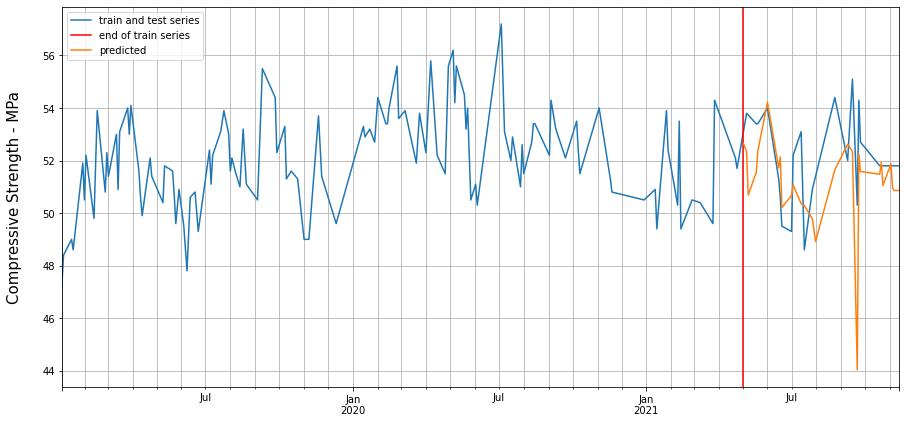

In [8]:
index = -98
plot_predictions(model, df_no_r3d_r7d, index, x, y)

<h3> Baseline model - Dataset: df_r3d_only</h3>

In [9]:
y = df_r3d_only['R28D'].values
x = df_r3d_only.drop(['Data/Hora', 'R28D'], axis=1).values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed, shuffle=False)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [10]:
model = get_baseline_model()
model.fit(x_train, y_train, batch_size=32, epochs=1000, verbose=0)
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 1ms/step - loss: 4.2275 - RMSE: 2.0561


[4.227479934692383, 2.0560836791992188]

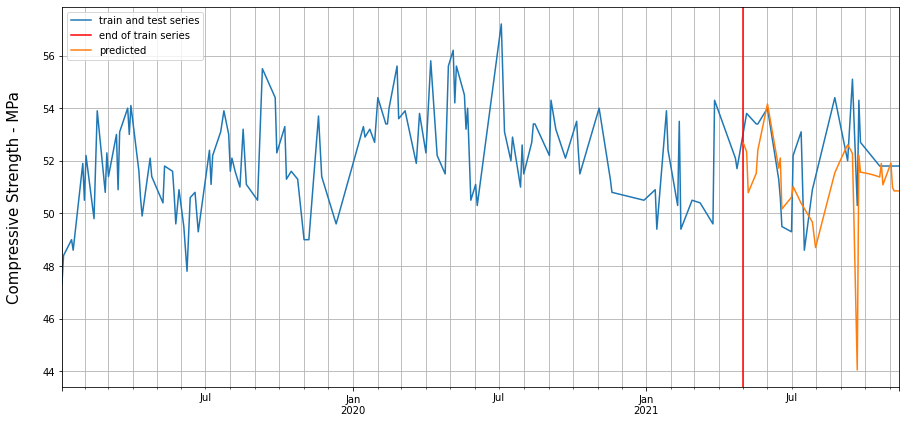

In [11]:
index = -98
plot_predictions(model, df_r3d_only, index, x, y)

<h3> Baseline model - Dataset: df_r3d_and_r7d</h3>

In [12]:
y = df_r3d_and_r7d['R28D'].values
x = df_r3d_and_r7d.drop(['Data/Hora', 'R28D'], axis=1).values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed, shuffle=False)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [13]:
model = get_baseline_model()
model.fit(x_train, y_train, batch_size=32, epochs=1000, verbose=0)
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 2ms/step - loss: 3.3120 - RMSE: 1.8199


[3.3120102882385254, 1.8198928833007812]

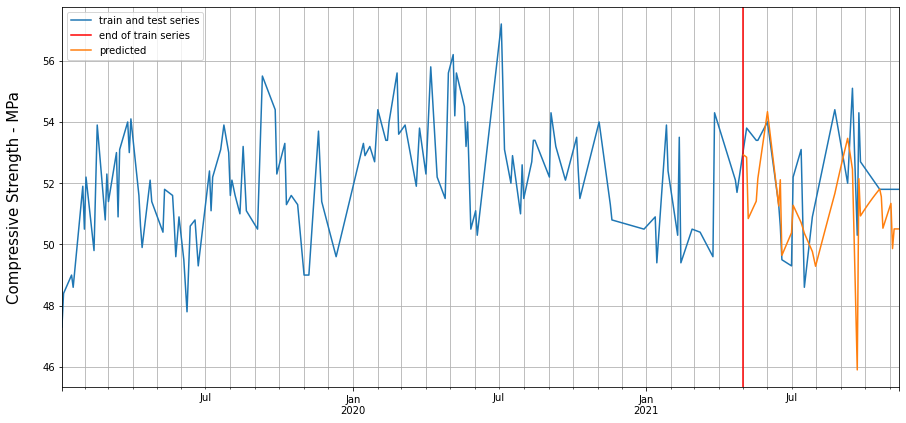

In [14]:
index = -98
plot_predictions(model, df_r3d_and_r7d, index, x, y)

# Grid Search CV

Before doing Repeated Cross Validation, we shall search for the best parameters. To do so, Keras Tuner will be used
to accomplish the Grid Search.

<h3> Grid Search 1<h3>

<h3>GridCV - Keras Tuner</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [15]:
def build_model(hp):    
    dropout_rate = hp.Choice("dropout_rate", [0.0, 0.1, 0.2, 0.25, 0.5])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model = tf.keras.Sequential()
    
    for n_layers in range(hp.Int('layers', 0, 10)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int('units_layer' + str(n_layers), min_value=32, max_value=512, step=32),
            activation=hp.Choice("activation", ["swish", "selu", "relu", "linear"])))
        #if hp.Boolean("dropout"):
        #    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units=1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")])
    return model

In [16]:
build_model(kt.HyperParameters())

In [17]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective=kt.Objective("val_RMSE", direction="min"),
    # max_trials=3,
    executions_per_trial=1,
    overwrite=False,
    directory="keras_tuner_dir",
    project_name="mlp-partner_i-CPIIE40",
    seed=seed
)

In [18]:
tuner.search(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Trial 10 Complete [00h 00m 12s]
val_RMSE: 1.1763885021209717

Best val_RMSE So Far: 1.1763885021209717
Total elapsed time: 00h 02m 02s
INFO:tensorflow:Oracle triggered exit


In [19]:
tuner.results_summary()

Results summary
Results in keras_tuner_dir/mlp-partner_i-CPIIE40
Showing 10 best trials
Objective(name='val_RMSE', direction='min')
Trial summary
Hyperparameters:
dropout_rate: 0.25
lr: 0.000254849985227742
layers: 6
units_layer0: 256
activation: linear
units_layer1: 352
units_layer2: 224
units_layer3: 96
units_layer4: 288
units_layer5: 64
units_layer6: 288
units_layer7: 64
units_layer8: 32
units_layer9: 128
Score: 1.1763885021209717
Trial summary
Hyperparameters:
dropout_rate: 0.25
lr: 0.0003069273045576997
layers: 10
units_layer0: 320
activation: selu
units_layer1: 32
units_layer2: 32
units_layer3: 32
units_layer4: 32
units_layer5: 32
units_layer6: 32
units_layer7: 32
units_layer8: 32
units_layer9: 32
Score: 16.32756233215332
Trial summary
Hyperparameters:
dropout_rate: 0.0
lr: 0.006599917029213527
layers: 3
units_layer0: 64
activation: relu
units_layer1: 448
units_layer2: 256
units_layer3: 224
units_layer4: 416
units_layer5: 416
units_layer6: 96
units_layer7: 160
units_layer8: 288
u

In [20]:
# Get the top 1 models.
models = tuner.get_best_models(num_models=1)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
# best_model.build()
# best_model.summary()

In [21]:
best_model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 2ms/step - loss: 1.3839 - RMSE: 1.1764


[1.3838897943496704, 1.1763885021209717]

In [22]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10240     
_________________________________________________________________
dense_1 (Dense)              (None, 352)               90464     
_________________________________________________________________
dense_2 (Dense)              (None, 224)               79072     
_________________________________________________________________
dense_3 (Dense)              (None, 96)                21600     
_________________________________________________________________
dense_4 (Dense)              (None, 288)               27936     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                18496     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6

<h3>GridCV - Scikit Learn</h3>

In [23]:
def create_keras_model(activation='swish', dropout_rate=0.0, n_units=0, n_layers=0, learning_rate=1e-3):
    model = tf.keras.Sequential()
    
    for _ in range(n_layers):
        model.add(tf.keras.layers.Dense(units=n_units, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")])
    return model

In [24]:
def make_grid_search(x, y):
    activation = ['relu', 'swish', 'selu', 'linear']
    dropout_rate = [0.0, 0.1]
    n_units = [16, 32]
    n_layers = [0, 1, 2, 3]
    learning_rate = [0.001, 0.01, 0.1]
    epochs = [200]
    batches = [32]

    param_grid = dict(model__activation=activation,
                      model__dropout_rate=dropout_rate, 
                      model__n_units=n_units,
                      model__n_layers=n_layers, 
                      model__learning_rate=learning_rate,
                      model__epochs=epochs,
                      model__batch_size=batches)

    model = KerasRegressor(build_fn=create_keras_model, epochs=30, batch_size=32, verbose=0)
    pipeline = Pipeline(steps=[('transformer', StandardScaler()), ('model', model)])

    grid = GridSearchCV(estimator=pipeline, 
                        param_grid=param_grid,
                        n_jobs=-1,
                        cv=3, 
                        scoring='neg_root_mean_squared_error')
    
    # grid_result = grid.fit(scaler.fit_transform(x), y)
    grid_result = grid.fit(x, y)

    print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid

<h3>GridCV 1</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.


In [25]:
y = df_no_r3d_r7d['R28D'].values
x = df_no_r3d_r7d.drop(['Data/Hora', 'R28D'], axis=1).values
start = time.time()
gridcv1 = make_grid_search(x, y)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

Best: -2.015057 using {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.1, 'model__epochs': 200, 'model__learning_rate': 0.1, 'model__n_layers': 3, 'model__n_units': 32}

-49.944638 (0.618563) with: {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_layers': 0, 'model__n_units': 16}
-49.751394 (0.841437) with: {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_layers': 0, 'model__n_units': 32}
-22.772734 (4.012037) with: {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 16}
-19.849532 (2.614633) with: {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_l

In [26]:
gridcv1.best_params_

{'model__activation': 'selu',
 'model__batch_size': 32,
 'model__dropout_rate': 0.1,
 'model__epochs': 200,
 'model__learning_rate': 0.1,
 'model__n_layers': 3,
 'model__n_units': 32}

In [27]:
mean_fit_time= gridcv1.cv_results_['mean_fit_time']
mean_score_time= gridcv1.cv_results_['mean_score_time']
n_splits  = gridcv1.n_splits_ #number of splits of training data
n_iter = pd.DataFrame(gridcv1.cv_results_).shape[0] #Iterations per split
print(np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter)

5284.572947263718


<h3>GridCV 2</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D is considered.

In [28]:
y = df_r3d_only['R28D'].values
x = df_r3d_only.drop(['Data/Hora', 'R28D'], axis=1).values
start = time.time()
gridcv2 = make_grid_search(x, y)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

Best: -1.824173 using {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.1, 'model__epochs': 200, 'model__learning_rate': 0.1, 'model__n_layers': 3, 'model__n_units': 32}

-49.221192 (0.953969) with: {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_layers': 0, 'model__n_units': 16}
-50.426211 (1.400245) with: {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_layers': 0, 'model__n_units': 32}
-23.214163 (1.727760) with: {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 16}
-19.215518 (2.624401) with: {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_l

In [29]:
gridcv2.best_params_

{'model__activation': 'relu',
 'model__batch_size': 32,
 'model__dropout_rate': 0.1,
 'model__epochs': 200,
 'model__learning_rate': 0.1,
 'model__n_layers': 3,
 'model__n_units': 32}

<h3>GridCV 3</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset R3D and R7D are considered.

In [30]:
y = df_r3d_and_r7d['R28D'].values
x = df_r3d_and_r7d.drop(['Data/Hora', 'R28D'], axis=1).values
start = time.time()
gridcv3 = make_grid_search(x, y)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

Best: -2.066105 using {'model__activation': 'linear', 'model__batch_size': 32, 'model__dropout_rate': 0.1, 'model__epochs': 200, 'model__learning_rate': 0.1, 'model__n_layers': 0, 'model__n_units': 16}

-49.439318 (1.112596) with: {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_layers': 0, 'model__n_units': 16}
-49.800657 (1.015905) with: {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_layers': 0, 'model__n_units': 32}
-25.862735 (5.921065) with: {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 16}
-19.491135 (4.173967) with: {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n

In [31]:
gridcv3.best_params_

{'model__activation': 'linear',
 'model__batch_size': 32,
 'model__dropout_rate': 0.1,
 'model__epochs': 200,
 'model__learning_rate': 0.1,
 'model__n_layers': 0,
 'model__n_units': 16}

<h2>Repeated KFold Cross validation</h2>

Here we will make a Repeated KFold Cross validation with all 3 datasets using the best parameters found
in the GridSearch cv

In [32]:
def make_repeated_kfold_cross_validation(grid, x, y):
    activation = grid.best_params_['model__activation']
    dropout_rate = grid.best_params_['model__dropout_rate']
    n_units = grid.best_params_['model__n_units']
    n_layers = grid.best_params_['model__n_layers']
    learning_rate = grid.best_params_['model__learning_rate']
    batch_size = grid.best_params_['model__batch_size']
    epochs = grid.best_params_['model__epochs']

    rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)
    scores = []

    start = time.time()
    for train, test in rkf.split(x):
        model = create_keras_model(activation=activation,
                                   dropout_rate=dropout_rate,
                                   n_units=n_units,
                                   n_layers=n_layers,
                                   learning_rate=learning_rate)
        model.fit(scaler.fit_transform(x[train]), y[train], epochs=epochs, batch_size=batch_size, verbose=0)
        rmse = model.evaluate(scaler.transform(x[test]), y[test], verbose=0)
        scores.append(rmse[1])
    
    print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    end = time.time()
    print("Minutes Elapsed: ", (end - start)/60)
    return rkf, scores

<h3>Experiment 1</h3>
<h4> Repeated KFold Cross Validation - df_no_r3d_r7d</h4>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [33]:
y = df_no_r3d_r7d['R28D'].values
x = df_no_r3d_r7d.drop(['Data/Hora', 'R28D'], axis=1).values
rkf1, scores = make_repeated_kfold_cross_validation(gridcv1, x, y)

RMSE: 3.187 (10.905)
Minutes Elapsed:  5.041162510712941


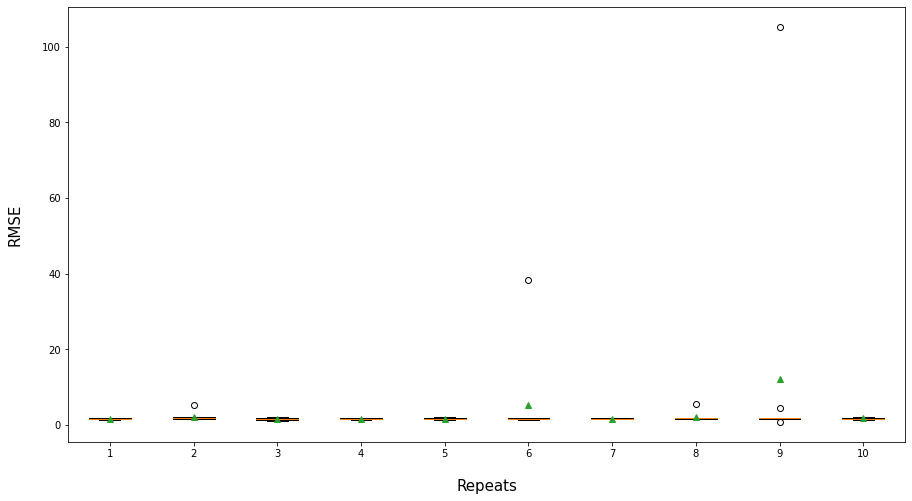

In [34]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(np.reshape(scores, (10,10)), labels=[str(r) for r in range(1, 11)], showmeans=True)
plt.show()

In [55]:
activation = gridcv1.best_params_['model__activation']
dropout_rate = gridcv1.best_params_['model__dropout_rate']
n_units = gridcv1.best_params_['model__n_units']
n_layers = gridcv1.best_params_['model__n_layers']
learning_rate = gridcv1.best_params_['model__learning_rate']
batch_size = gridcv1.best_params_['model__batch_size']
epochs = gridcv1.best_params_['model__epochs']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed, shuffle=False)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = create_keras_model(activation=activation,
                                   dropout_rate=dropout_rate,
                                   n_units=n_units,
                                   n_layers=n_layers,
                                   learning_rate=learning_rate)

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 1.187


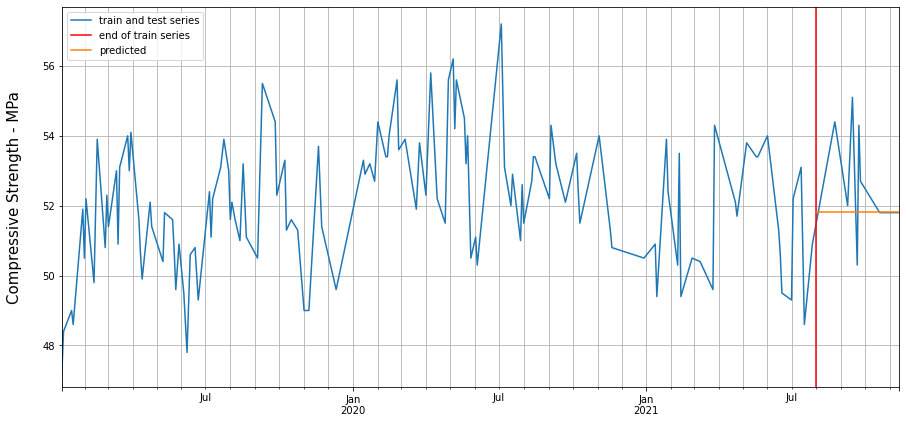

In [56]:
index = -53
plot_predictions(model, df_no_r3d_r7d, index, x, y)

<h3>Experiment 2</h3>
<h4> Repeated KFold Cross Validation - df_r3d_only</h4>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D is considered.

In [37]:
y = df_r3d_only['R28D'].values
x = df_r3d_only.drop(['Data/Hora', 'R28D'], axis=1).values
rkf2, scores = make_repeated_kfold_cross_validation(gridcv2, x, y)

RMSE: 0.896 (0.239)
Minutes Elapsed:  5.048380223910014


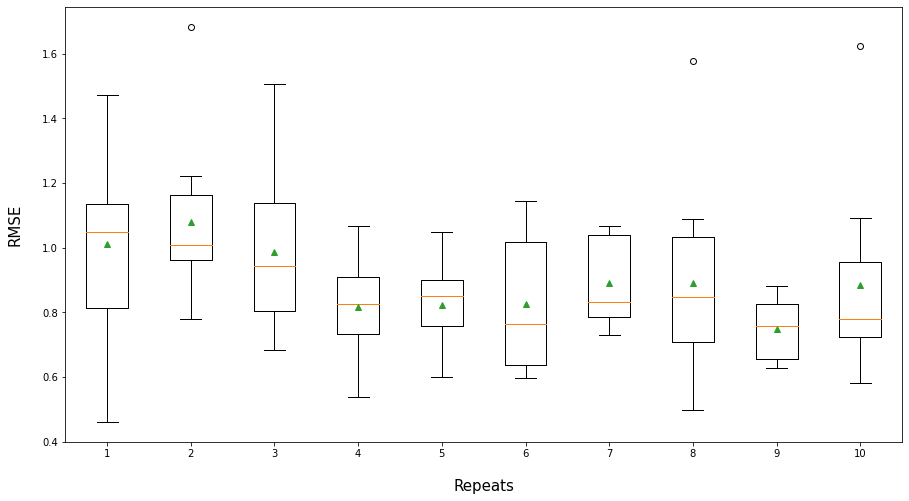

In [38]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(np.reshape(scores, (10,10)), labels=[str(r) for r in range(1, 11)], showmeans=True)
plt.show()

In [53]:
activation = gridcv2.best_params_['model__activation']
dropout_rate = gridcv2.best_params_['model__dropout_rate']
n_units = gridcv2.best_params_['model__n_units']
n_layers = gridcv2.best_params_['model__n_layers']
learning_rate = gridcv2.best_params_['model__learning_rate']
batch_size = gridcv2.best_params_['model__batch_size']
epochs = gridcv2.best_params_['model__epochs']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed, shuffle=False)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = create_keras_model(activation=activation,
                                   dropout_rate=dropout_rate,
                                   n_units=n_units,
                                   n_layers=n_layers,
                                   learning_rate=learning_rate)

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 2.015


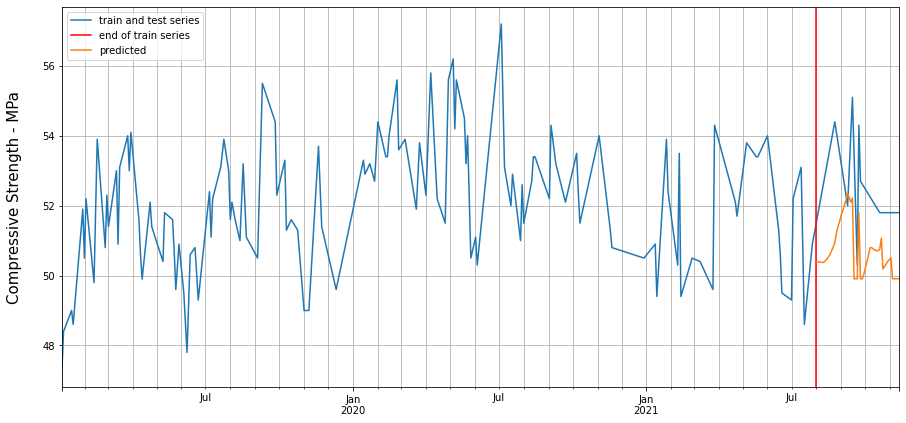

In [54]:
index = -53
plot_predictions(model, df_r3d_only, index, x, y)

<h3>Experiment 3</h3>
<h4> Repeated KFold Cross Validation - df_r3d_and_r7d</h4>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D are considered.        

In [41]:
y = df_r3d_and_r7d['R28D'].values
x = df_r3d_and_r7d.drop(['Data/Hora', 'R28D'], axis=1).values
rkf3, scores = make_repeated_kfold_cross_validation(gridcv3, x, y)

RMSE: 1.212 (0.135)
Minutes Elapsed:  3.6519283850987754


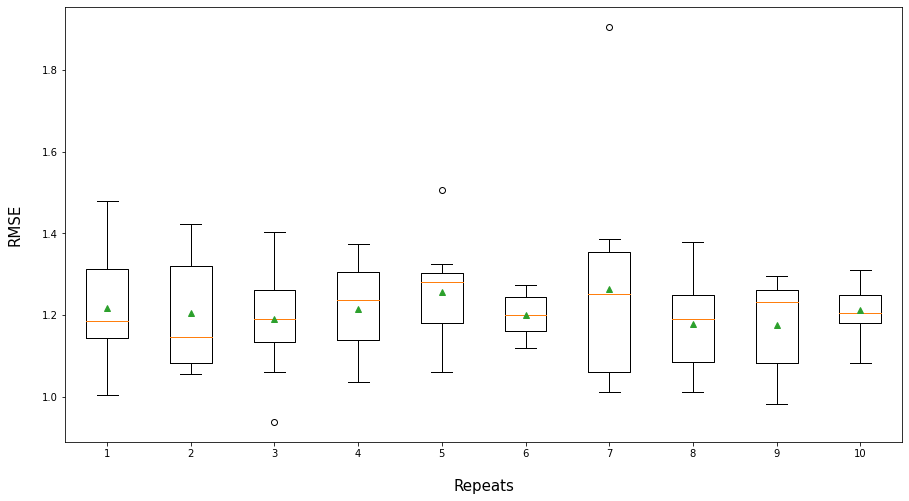

In [42]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(np.reshape(scores, (10,10)), labels=[str(r) for r in range(1, 11)], showmeans=True)
plt.show()

In [51]:
activation = gridcv3.best_params_['model__activation']
dropout_rate = gridcv3.best_params_['model__dropout_rate']
n_units = gridcv3.best_params_['model__n_units']
n_layers = gridcv3.best_params_['model__n_layers']
learning_rate = gridcv3.best_params_['model__learning_rate']
batch_size = gridcv3.best_params_['model__batch_size']
epochs = gridcv3.best_params_['model__epochs']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=seed, shuffle=False)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = create_keras_model(activation=activation,
                                   dropout_rate=dropout_rate,
                                   n_units=n_units,
                                   n_layers=n_layers,
                                   learning_rate=learning_rate)

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 1.716


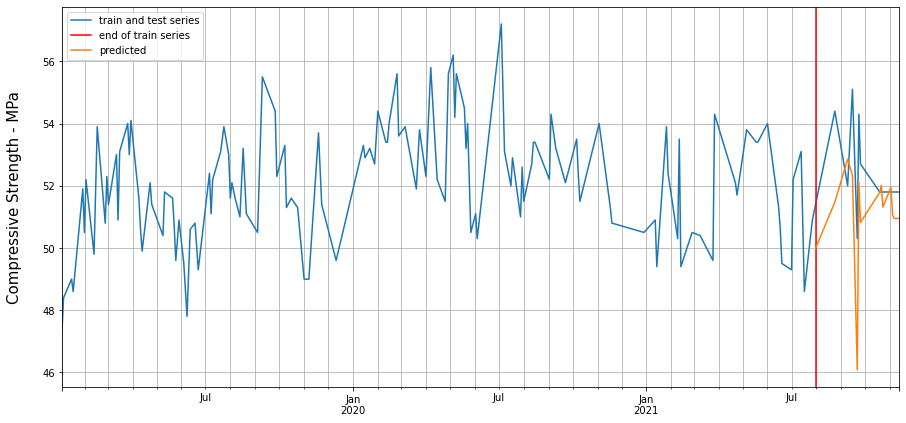

In [52]:
index = -53
plot_predictions(model, df_r3d_and_r7d, index, x, y)